In [1]:
import cv2
import numpy as np

In [2]:
from google.colab.patches import cv2_imshow

In [ ]:
# Check GPU availability
import tensorflow as tf
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "not available")

GPU is available


In [3]:
def equalize_image(image):
  # Split the image into individual bands
  bands = cv2.split(image)

  # Apply histogram equalization to each band separately
  equalized_bands = []
  for band in bands:
      equalized_band = cv2.equalizeHist(band)
      equalized_bands.append(equalized_band)

  # Merge the equalized bands back into a single image
  equalized_image = cv2.merge(equalized_bands)

  return equalized_image

In [4]:
def get_ndwi(image):
  # Split channels
  b, g, r = cv2.split(image)

  # Convert to floating point to avoid overflow issues
  b = b.astype(np.float32)
  g = g.astype(np.float32)

  # Calculate NDWI
  ndwi = (g - b) / (g + b + 1e-9)

  # Normalize NDWI to the range [0, 255] for visualization
  ndwi_normalized = cv2.normalize(ndwi, None, 0, 255, cv2.NORM_MINMAX)

  # Convert to uint8 for display
  ndwi_normalized = ndwi_normalized.astype(np.uint8)

  return ndwi_normalized


In [5]:
image1 = cv2.imread('img_1001.png')
image2 = cv2.imread('img_1009.png')
image3 = cv2.imread('img_1038.png')

In [6]:
image1.shape

(320, 320, 3)

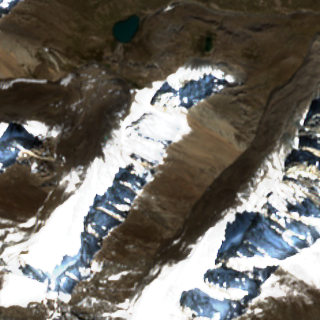

In [7]:
cv2_imshow(image1)

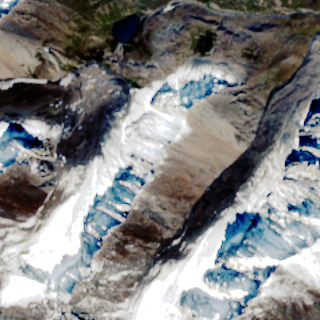

In [8]:
equalized_image1 = equalize_image(image1)
cv2_imshow(equalized_image1)

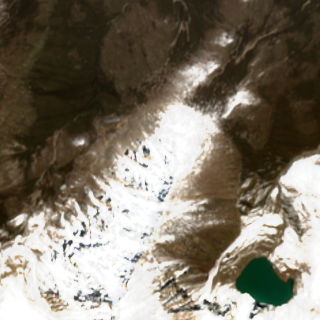

In [9]:
cv2_imshow(image2)

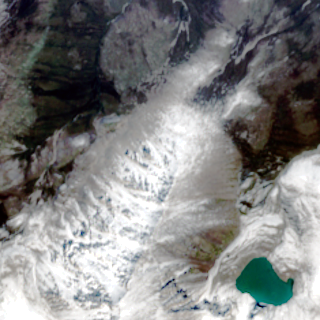

In [10]:
equalized_image2 = equalize_image(image2)
cv2_imshow(equalized_image2)

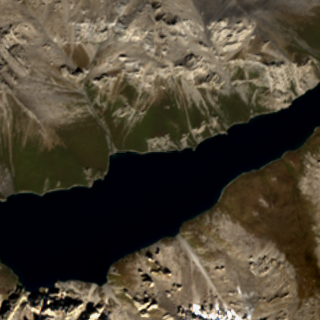

In [11]:
cv2_imshow(image3)

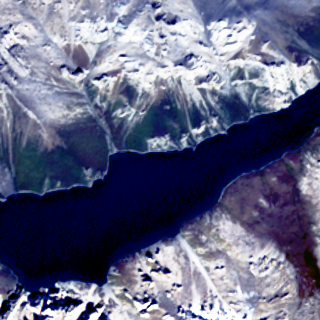

In [12]:
equalized_image3 = equalize_image(image3)
cv2_imshow(equalized_image3)

# Gaussian Blur

In [13]:
# Apply Gaussian blur to smooth the image
blurred_image1 = cv2.GaussianBlur(equalized_image1, (5, 5), 0)

In [14]:
blurred_image2 = cv2.GaussianBlur(equalized_image2, (5, 5), 0)

In [15]:
blurred_image3 = cv2.GaussianBlur(equalized_image3, (5, 5), 0)

# NDWI

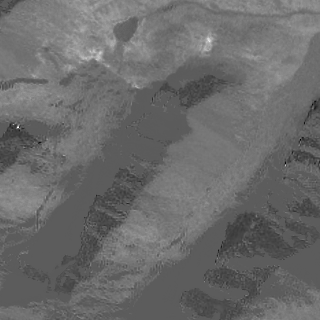

In [16]:
ndwi1 = get_ndwi(image1)
cv2_imshow(ndwi1)

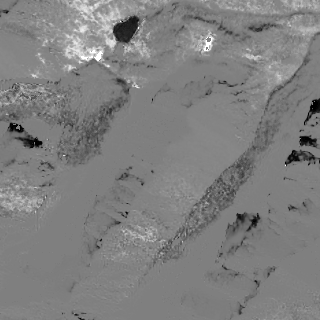

In [17]:
ndwi1_eq = get_ndwi(equalized_image1)
cv2_imshow(ndwi1_eq)

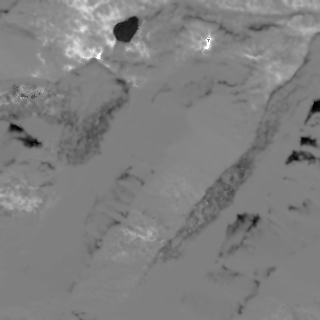

In [18]:
ndwi1_eq_blr = get_ndwi(blurred_image1)
cv2_imshow(ndwi1_eq_blr)

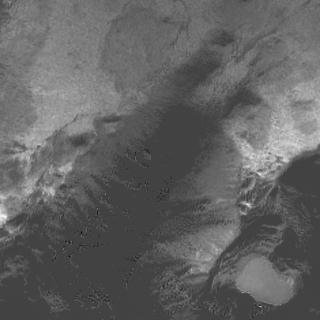

In [19]:
ndwi2 = get_ndwi(image2)
cv2_imshow(ndwi2)

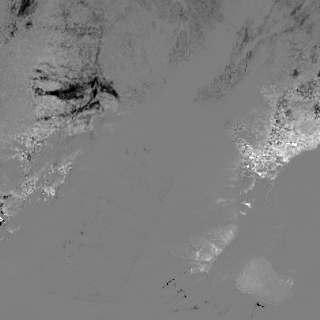

In [20]:
ndwi2_eq = get_ndwi(equalized_image2)
cv2_imshow(ndwi2_eq)

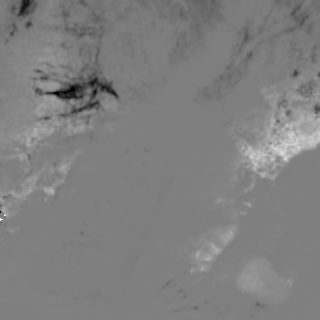

In [21]:
ndwi2_eq_blr = get_ndwi(blurred_image2)
cv2_imshow(ndwi2_eq_blr)

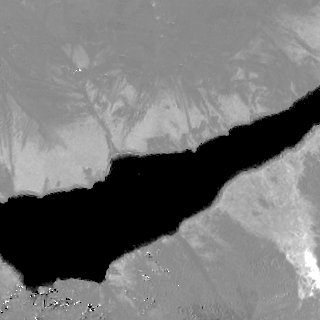

In [22]:
ndwi3 = get_ndwi(image3)
cv2_imshow(ndwi3)

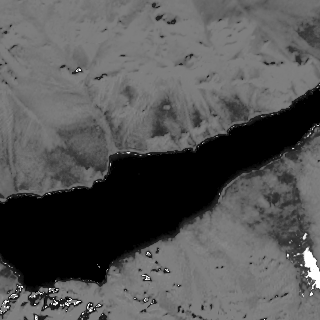

In [23]:
ndwi3_eq = get_ndwi(equalized_image3)
cv2_imshow(ndwi3_eq)

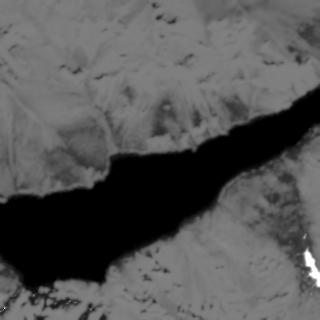

In [24]:
ndwi3_eq_blr = get_ndwi(blurred_image3)
cv2_imshow(ndwi3_eq_blr)

In [25]:
def find_contours(image):
  # Perform Canny edge detection
  edges = cv2.Canny(image, 30, 150)

  # Find contours of objects in the Canny edge-detected image
  contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

  # Create a mask to draw contours on
  contour_mask = np.zeros_like(image)

  # Draw contours of detected objects (presumably glacial lakes)
  cv2.drawContours(contour_mask, contours, -1, (255), thickness=cv2.FILLED)
  return edges, contour_mask


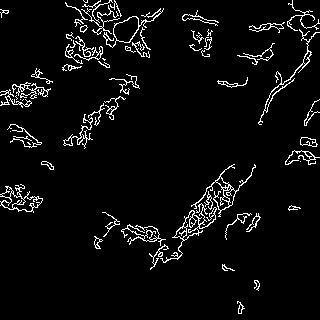

In [26]:
image1_edges, image1_contour = find_contours(ndwi1_eq_blr)
cv2_imshow(image1_edges)

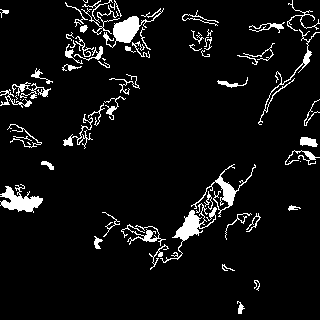

In [27]:
cv2_imshow(image1_contour)

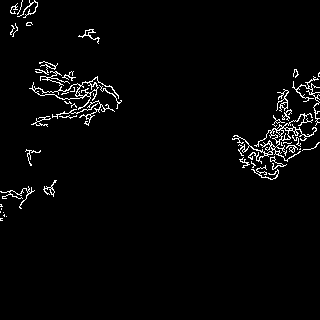

In [28]:
image2_edges, image2_contour = find_contours(ndwi2_eq_blr)
cv2_imshow(image2_edges)

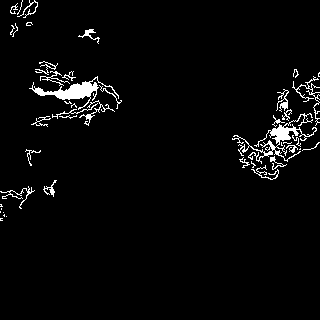

In [29]:
cv2_imshow(image2_contour)

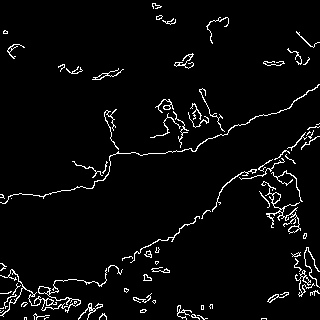

In [30]:
image3_edges, image3_contour = find_contours(ndwi3_eq_blr)
cv2_imshow(image3_edges)

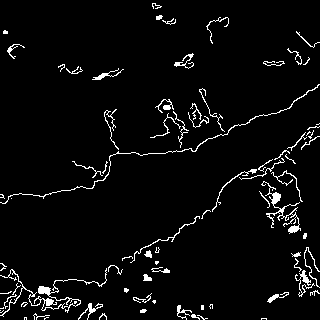

In [31]:
cv2_imshow(image3_contour)

In [33]:
def find_contours_rounded2(image):
  # Perform Canny edge detection
  edges = cv2.Canny(image, 30, 150)

  # Find contours of objects in the Canny edge-detected image
  contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # Filter contours to isolate the lake boundary
  lake_contours = []

  # Filter contours based on area relative to the entire image area
  image_area = image.shape[0] * image.shape[1]
  min_contour_area = 0.005 * image_area

  for contour in contours:
      contour_area = cv2.contourArea(contour)
      if min_contour_area < contour_area:
          lake_contours.append(contour)

          # Approximate the contour to reduce the number of points
          epsilon = 0.001 * cv2.arcLength(contour, True)
          approx = cv2.approxPolyDP(contour, epsilon, True)

          # Check if the contour is convex and has a large enough area
          if cv2.isContourConvex(approx) and cv2.contourArea(approx) > 1000:
              lake_contours.append(approx)

  # Create a mask to draw contours on
  contour_mask = np.zeros_like(image)

  # Draw contours of detected objects (presumably glacial lakes)
  cv2.drawContours(contour_mask, lake_contours, -1, (255), thickness = cv2.FILLED)
  return contour_mask

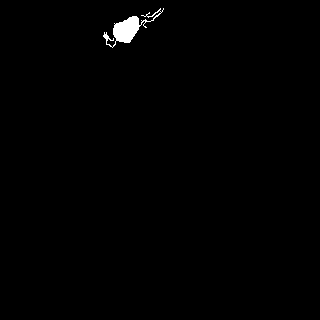

In [34]:
image1_edges_r = find_contours_rounded2(ndwi1_eq_blr)
cv2_imshow(image1_edges_r)

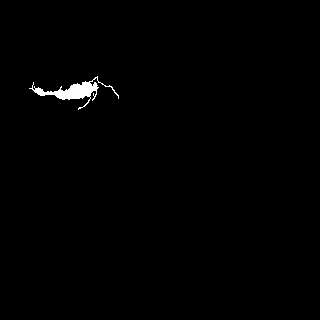

In [36]:
image2_edges_r = find_contours_rounded2(ndwi2_eq_blr)
cv2_imshow(image2_edges_r)

# **Classification**

In [ ]:
import os
import zipfile

In [ ]:
def load_images_from_folder(folder):
    #images = []
    images = {}
    for filename in os.listdir(folder):
        if filename.endswith('.png'):
            img = cv2.imread(os.path.join(folder, filename))
            if img is not None:
              images[filename] = img
                #images.append(img)
    return images

In [ ]:
# To unzip the archive 'Glacial Lakes Detection Dataset.zip' in the current directory

f_name = 'Glacial_Lakes_Detection_Dataset.zip'
#f_name = 'Glacial_Lake.zip'

with zipfile.ZipFile(f_name, 'r') as fd:
    fd.extractall('.')

In [ ]:
# Define paths to the folders

train_images_folder = 'train'
train_labels_folder = 'train_label'
test_images_folder = 'test'
test_labels_folder = 'test_label'

In [ ]:
# Load images from train and test folders
train_images = load_images_from_folder(train_images_folder)
train_labels = load_images_from_folder(train_labels_folder)
test_images = load_images_from_folder(test_images_folder)
test_labels = load_images_from_folder(test_labels_folder)

In [ ]:
# Display the number of images loaded
print(f"Number of train images: {len(train_images)}")
print(f"Number of train labels: {len(train_labels)}")
print(f"Number of test images: {len(test_images)}")
print(f"Number of test labels: {len(test_labels)}")

Number of train images: 176
Number of train labels: 171
Number of test images: 24
Number of test labels: 24


In [ ]:
set(os.listdir('train')) - set(os.listdir('train')).intersection(set(os.listdir('train_label')))

set()

In [ ]:
# Find images present in both train and test sets
common_train_images = {filename: train_images[filename] for filename in train_images if filename in train_labels}

# Separate the images and labels
train_images = [common_train_images[filename] for filename in common_train_images]
train_labels = [train_labels[filename] for filename in common_train_images]

print(f"Number of common images between train_images and train_labels: {len(common_train_images)}")

Number of common images between train_images and train_labels: 171


In [ ]:
# Find images present in both train and test sets
common_test_images = {filename: test_images[filename] for filename in test_images if filename in test_labels}

# Separate the images and labels
test_images = [common_test_images[filename] for filename in common_test_images]
test_labels = [test_labels[filename] for filename in common_test_images]

print(f"Number of common images between test_images and test_labels: {len(common_test_images)}")

Number of common images between test_images and test_labels: 24


In [ ]:
# Convert lists to numpy arrays

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [ ]:
#!rm -rf train
#!rm -rf train_label
#!rm -rf test
#!rm -rf test_label

In [ ]:
def preprocess_dataset(images):
  preprocess_images = []
  lake_cnt = []


  for image in images:
    equalized_image = equalize_image(image)

    # Apply Gaussian blur to smooth the image
    blurred_image = cv2.GaussianBlur(equalized_image, (5, 5), 0)

    ndwi_eq_blr = get_ndwi(blurred_image)

    image_edges_r, num_lake = find_contours_rounded2(ndwi_eq_blr)
    lake_cnt.append(num_lake)

    preprocess_images.append(image_edges_r)

  return preprocess_images, lake_cnt


In [ ]:
prepocessed_train = preprocess_dataset(train_images)

In [ ]:
prepocessed_test = preprocess_dataset(test_images)

In [ ]:
# Convert lists to numpy arrays

train_data = np.array(prepocessed_train)
test_data = np.array(prepocessed_test)

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, mean_squared_error

In [ ]:
def random_forest_classification(train_images, train_labels, test_images):
  train_data = train_images.reshape(len(train_images), -1)
  test_data = train_images.reshape(len(train_images), -1)
  train_labels = train_labels.reshape(len(train_labels), -1)

  rf_clf = RandomForestClassifier(max_depth = 100, random_state = 42)
  rf_clf.fit(train_data, train_labels)

  # Predict labels for test images
  predicted_labels = rf_clf.predict(test_images)

  # Calculate predicted area for each image
  predicted_areas = []
  for label in predicted_labels:
    predicted_area = np.sum(label == 255)  # Count of white pixels
    predicted_areas.append(predicted_area)

  return predicted_labels, predicted_areas

In [ ]:
# Define the function to compute performance metrics
def compute_performance_metrics(predicted_labels, true_labels):
    # Flatten the predicted and true labels
    predicted_labels_flat = predicted_labels.flatten()
    true_labels_flat = true_labels.flatten()

    # Compute pixel accuracy
    pixel_accuracy = accuracy_score(true_labels_flat, predicted_labels_flat)

    # Compute intersection and union
    intersection = np.sum(np.logical_and(predicted_labels, true_labels))
    union = np.sum(np.logical_or(predicted_labels, true_labels))

    # Compute Dice Index
    dice_index = 2 * intersection / (np.sum(predicted_labels) + np.sum(true_labels))

    # Compute intersection over union (IoU)
    intersection_over_union = intersection / union

    # Compute recall
    recall = recall_score(true_labels_flat, predicted_labels_flat)

    # Compute F1 score for boundary pixels
    f1_boundary = f1_score(true_labels_flat, predicted_labels_flat)

    return pixel_accuracy, dice_index, intersection_over_union, recall, f1_boundary


In [ ]:
# Perform Random Forest classification
predicted_labels, predicted_areas = random_forest_classification(train_data, train_labels, test_data)

In [ ]:
# Compute performance metrics
pixel_accuracy, dice_index, intersection_over_union, recall, f1_boundary = compute_performance_metrics(predicted_labels, test_labels)

In [ ]:
# Print performance metrics
print(f"Pixel Accuracy: {pixel_accuracy}")
print(f"Dice Index: {dice_index}")
print(f"Intersection over Union: {intersection_over_union}")
print(f"Recall: {recall}")
print(f"F1 Boundary: {f1_boundary}")

In [ ]:
# Compute actual areas of the lakes from the ground truth labels
actual_areas = [np.sum(label == 255) for label in test_labels]

In [ ]:
# Calculate MSE between actual and predicted areas
mse = mean_squared_error(actual_areas, predicted_areas)
print(f"Mean Squared Error (MSE) between actual and predicted areas: {mse}")